In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = [8, 6]

In [2]:
with open("logs/evaluation.json", "r") as f:
    result = json.load(f)

result_train = []
backbones = {
    "resnet26d": "ResNet-26D",
    "convnext_nano": "ConvNeXt Nano",
    "resmlp_12_224": "ResMLP-12-224",
    "densenet169": "DenseNet-169",
}
for backbone in backbones:
    result_train.append(pd.read_csv(f"logs/{backbone}.csv"))
    result_train[-1]["Model"] = backbones[backbone]
    epochs = []
    for i in range(200):
        epochs.extend([i + 1, i + 1])
    result_train[-1]["Epoch"] = epochs

result_train = pd.concat(result_train)
result_train[["Accuracy", "F1-Macro"]] *= 100
result_train[["Loss", "Accuracy", "F1-Macro"]] = result_train[
    ["Loss", "Accuracy", "F1-Macro"]
].round(2)
result_train

,Subset,Loss,Accuracy,F1-Macro,Model,Epoch
0,Train,2.11,12.83,12.44,ResNet-26D,1
1,Valid,2.06,17.76,15.74,ResNet-26D,1
2,Train,2.07,17.26,16.43,ResNet-26D,2
3,Valid,1.97,25.10,23.80,ResNet-26D,2
4,Train,1.99,23.88,22.46,ResNet-26D,3
...,...,...,...,...,...,...
395,Valid,1.08,64.86,64.83,DenseNet-169,198
396,Train,0.89,72.75,72.64,DenseNet-169,199
397,Valid,1.08,64.86,64.92,DenseNet-169,199
398,Train,0.89,73.46,73.36,DenseNet-169,200


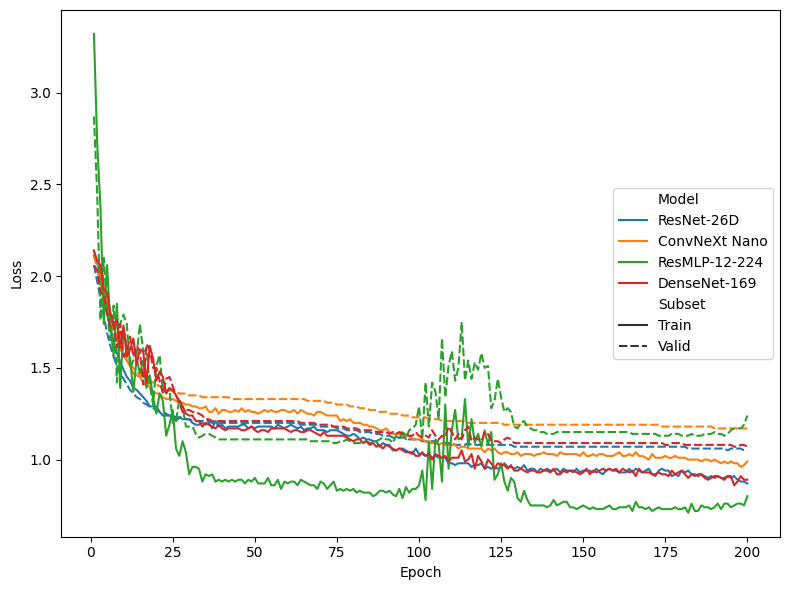

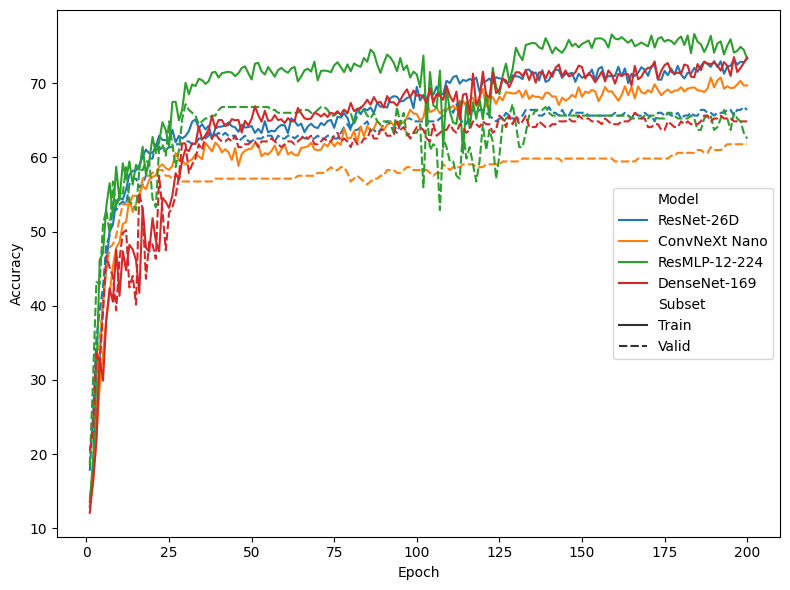

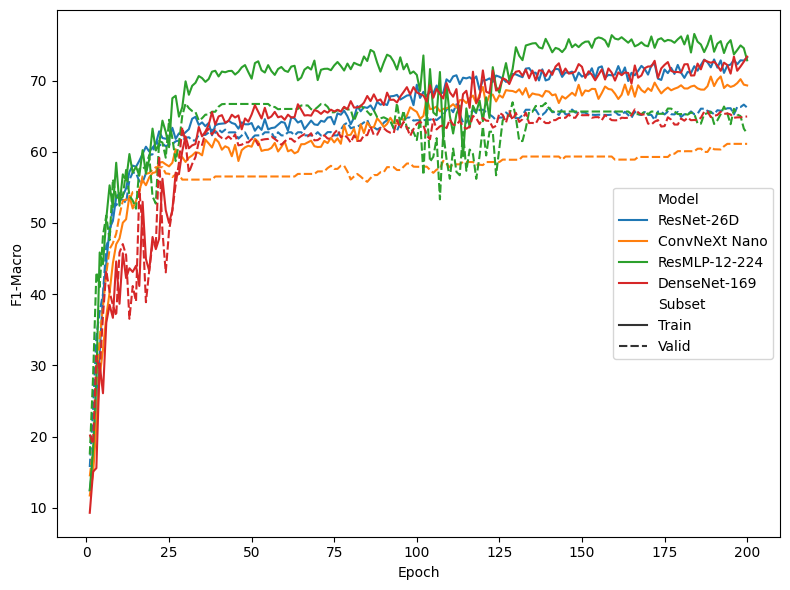

In [3]:
plt.figure()
sns.lineplot(data=result_train, x="Epoch", y="Loss", hue="Model", style="Subset")
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("logs/loss_dl_train.pdf")
plt.show()

plt.figure()
sns.lineplot(data=result_train, x="Epoch", y="Accuracy", hue="Model", style="Subset")
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("logs/accuracy_dl_train.pdf")
plt.show()

plt.figure()
sns.lineplot(data=result_train, x="Epoch", y="F1-Macro", hue="Model", style="Subset")
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("logs/f1_dl_train.pdf")
plt.show()

In [4]:
result_clean = []
for backbone in backbones:
    result_clean.append({"Model": backbones[backbone], **result[backbone]["default"]})
result_clean = pd.DataFrame(result_clean)
result_clean[["Accuracy", "F1-Macro"]] *= 100
result_clean[["Loss", "Accuracy", "F1-Macro"]] = result_clean[
    ["Loss", "Accuracy", "F1-Macro"]
].round(2)

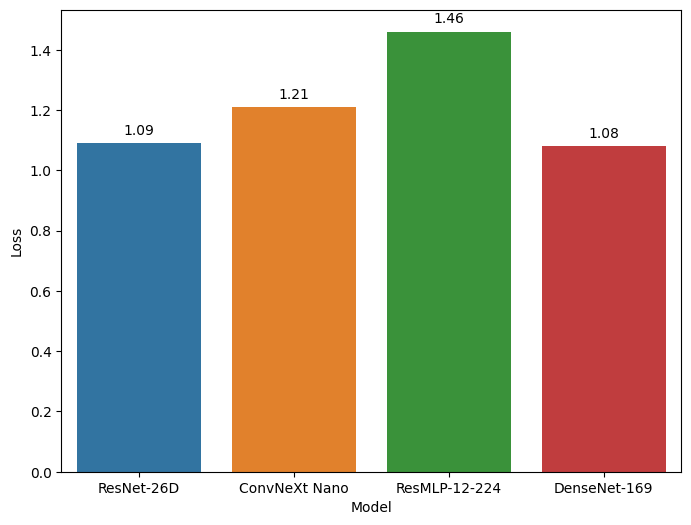

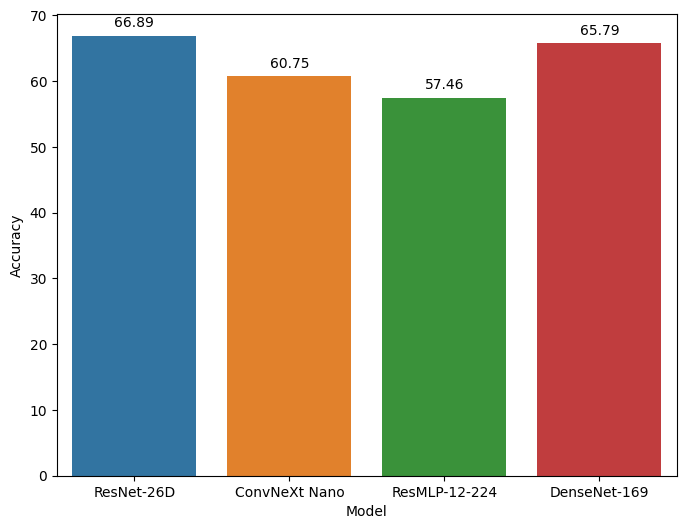

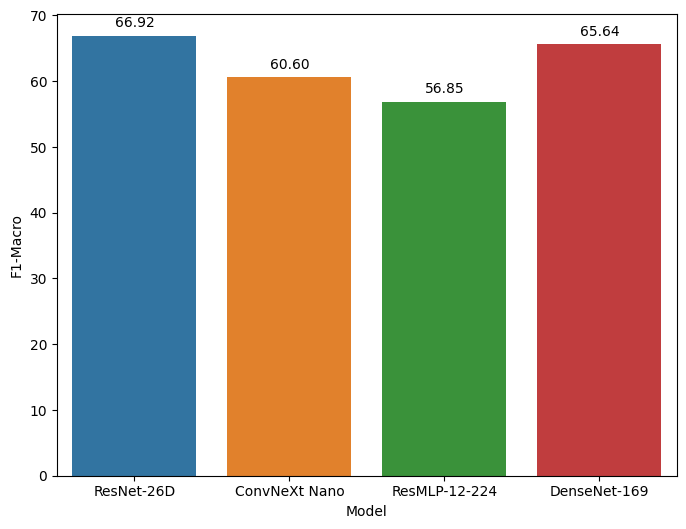

In [5]:
plt.figure()
ax = sns.barplot(data=result_clean, x="Model", y="Loss")
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )
plt.savefig("logs/accuracy_loss.pdf")
plt.show()

plt.figure()
ax = sns.barplot(data=result_clean, x="Model", y="Accuracy")
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )
plt.savefig("logs/accuracy_dl_clean.pdf")

plt.figure()
ax = sns.barplot(data=result_clean, x="Model", y="F1-Macro")
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )
plt.savefig("logs/f1_dl_clean.pdf")

In [6]:
backbones_idx = {v: k for k, v in backbones.items()}
best_model = result_clean["F1-Macro"].idxmax()

result_perturbed = result[backbones_idx[result_clean["Model"][best_model]]]

data = []
for perturbation in result_perturbed:
    if perturbation == "default":
        continue
    name = " ".join(perturbation.split("_")).title()
    for value in result_perturbed[perturbation]:
        data.append(
            {
                "Perturbation": name,
                "Value": round(float(value), 2),
                "Loss": result_perturbed[perturbation][value]["Loss"],
                "Accuracy": result_perturbed[perturbation][value]["Accuracy"],
                "F1-Macro": result_perturbed[perturbation][value]["F1-Macro"],
            }
        )
result_perturbed = pd.DataFrame(data)
result_perturbed = result_perturbed.sort_values(["Perturbation", "Value"])
result_perturbed.to_csv("logs/resnet_perturbation.csv")
display(result_perturbed)

,Perturbation,Value,Loss,Accuracy,F1-Macro
65,Brightness Decrease,0.00,1.101683,0.669623,0.669508
62,Brightness Decrease,5.00,1.101935,0.662971,0.663016
64,Brightness Decrease,10.00,1.107042,0.665188,0.665148
67,Brightness Decrease,15.00,1.112217,0.658537,0.658313
68,Brightness Decrease,20.00,1.114886,0.658537,0.658450
...,...,...,...,...,...
27,Salt And Pepper,0.10,1.917515,0.272727,0.242162
25,Salt And Pepper,0.12,2.039164,0.221729,0.189564
26,Salt And Pepper,0.14,2.118686,0.164080,0.110048
21,Salt And Pepper,0.16,2.165085,0.157428,0.091596
